In [5]:
!pip install timm
!clear

In [6]:
import io
import requests
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id

In [7]:
paths = ['/content/oranges.jpg', '/content/orange.jpg', '/content/orange-kitten-pink-flowers.jpg']
segmented_paths = []

for path in paths:
    # Cargar la imagen
    image = Image.open(path)

    # Cargar el modelo y el extractor de características
    feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
    model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

    # Preparar la imagen para el modelo
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Paso forward
    outputs = model(**inputs)

    # Postprocesamiento
    processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
    result = feature_extractor.post_process_panoptic(outputs, processed_sizes, threshold=0.85)[0]

    # Convertir la segmentación a numpy
    panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
    panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
    panoptic_seg_id = rgb_to_id(panoptic_seg)

    # Preparar la paleta de colores
    palette = itertools.cycle(sns.color_palette())

    # Crear la imagen segmentada
    segmented_image = Image.fromarray(np.zeros_like(panoptic_seg, dtype=np.uint8))
    draw = ImageDraw.Draw(segmented_image)

    # Añadimos un mapeo manual de los IDs de las categorías a los nombres, basado en las clases comunes de COCO
    COCO_LABELS = {
        1: 'persona', 2: 'bicicleta', 3: 'coche', 4: 'motocicleta', 5: 'avión',
        6: 'autobús', 7: 'tren', 8: 'camión', 9: 'barco', 10: 'semáforo',
        11: 'hidrante', 13: 'señal de stop', 14: 'parquímetro', 15: 'banco', 16: 'pájaro',
        17: 'gato', 18: 'perro', 19: 'caballo', 20: 'oveja', 21: 'vaca',
        22: 'elefante', 23: 'oso', 24: 'cebra', 25: 'jirafa', 27: 'mochila',
        28: 'paraguas', 31: 'bolso de mano', 32: 'corbata', 33: 'maleta', 34: 'frisbee',
        36: 'tabla de snowboard', 37: 'pelota deportiva', 38: 'cometa', 39: 'bate de béisbol',
        40: 'guante de béisbol', 41: 'patineta', 42: 'tabla de surf', 43: 'raqueta de tenis',
        44: 'botella', 46: 'plato de vino', 47: 'taza', 48: 'tenedor', 49: 'cuchillo',
        50: 'cuchara', 51: 'tazón', 52: 'banana', 53: 'manzana', 54: 'sándwich',
        55: 'naranja', 56: 'brócoli', 57: 'zanahoria', 58: 'perrito caliente', 59: 'pizza',
        60: 'donut', 61: 'pastel', 62: 'silla', 63: 'sofá', 64: 'maceta', 65: 'cama',
        67: 'mesa de comedor', 70: 'inodoro', 72: 'TV', 73: 'computadora portátil', 74: 'ratón',
        75: 'control remoto', 76: 'teclado', 77: 'teléfono celular', 78: 'microondas',
        79: 'horno', 80: 'tostadora', 81: 'fregadero', 82: 'refrigerador', 84: 'libro',
        85: 'reloj', 86: 'florero', 87: 'tijeras', 88: 'oso de peluche', 89: 'secador de pelo',
        90: 'cepillo de dientes',
    }

    # Ajusta el bucle para dibujar segmentos y etiquetas correctamente
    for segment_info in result["segments_info"]:
        class_id = segment_info["category_id"]
        class_name = COCO_LABELS.get(class_id, 'Desconocido')  # 'Desconocido' si el ID no está en el diccionario
        id = segment_info["id"]

        # Generar la máscara para este segmento específico
        mask = panoptic_seg_id == id
        color = np.array(next(palette)) * 255  # Convertir el color a un array de numpy adecuado

        # Convertir la máscara a una imagen de PIL para usarla como máscara en 'paste'
        mask_image = Image.fromarray((mask * 255).astype(np.uint8))

        # Crear una imagen del color del segmento que tenga las dimensiones correctas
        color_image = Image.new("RGB", segmented_image.size, color=tuple(color.astype(int)))

        # Pegar usando la máscara para aplicar solo este segmento
        segmented_image.paste(color_image, (0,0), mask=mask_image)

        # Dibujar el nombre de la clase en la posición inicial del segmento
        draw = ImageDraw.Draw(segmented_image)
        where = np.where(mask)
        if where[0].size > 0 and where[1].size > 0:
            x, y = np.min(where[1]), np.min(where[0])
            draw.text((x, y), class_name, fill='white')

    segmented_paths.append(segmented_image)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/172M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
`post_process_panoptic is deprecated and will be removed in v5 o

In [9]:
images = []
for path in paths:
    image = Image.open(path)
    images.append(image)


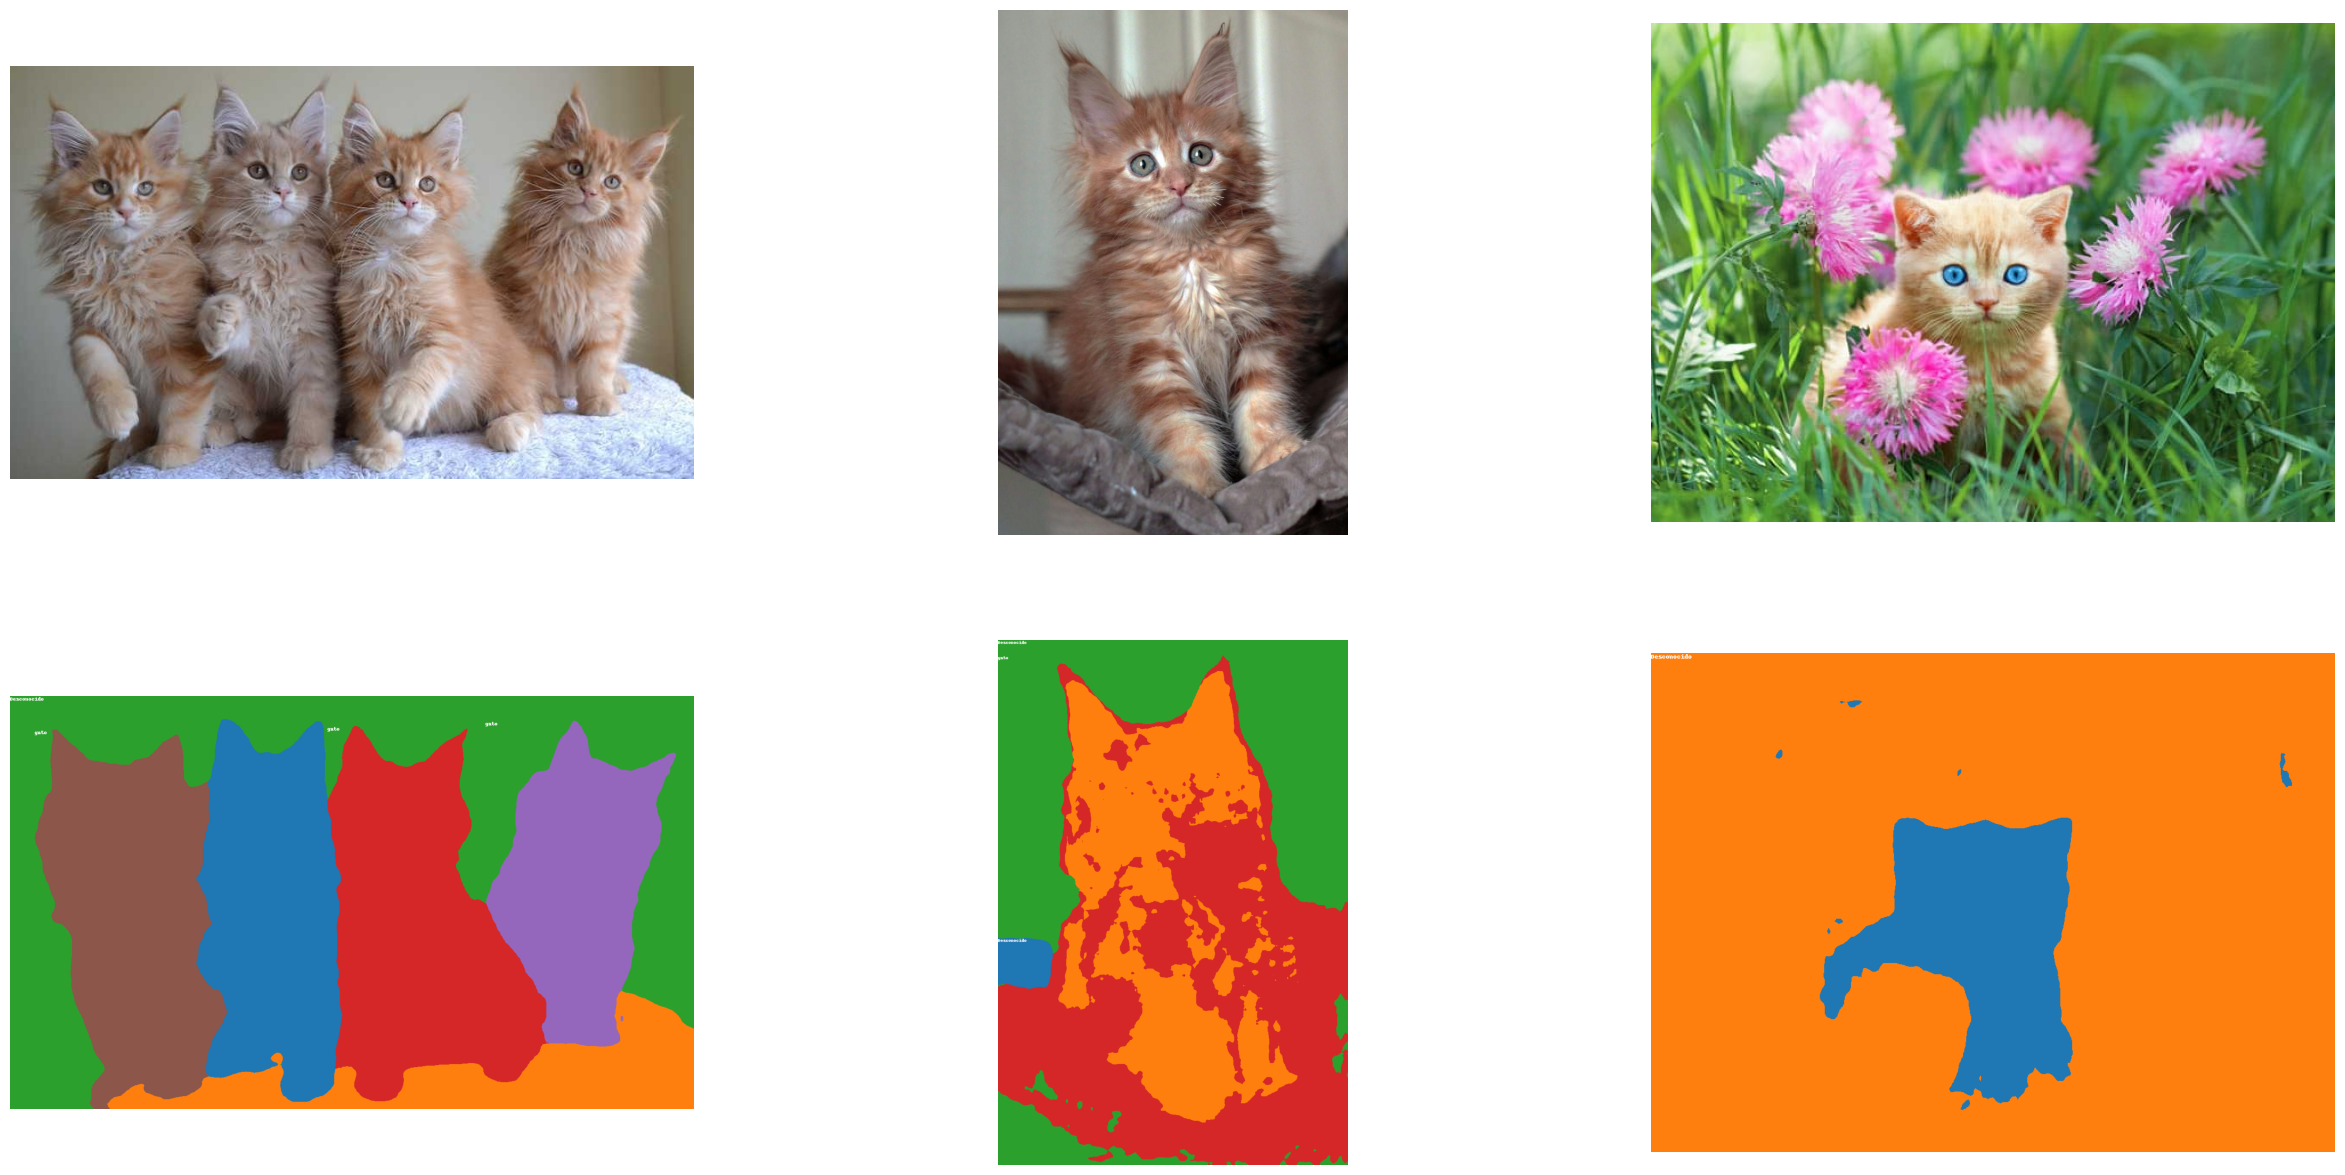

In [12]:
plt.figure(figsize=(30, 15))

for i in range(3):
    # Originals
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')

for i in range(3):
    # Segmented
    plt.subplot(2, 3, i+4)
    plt.imshow(segmented_paths[i])
    plt.axis('off')

plt.show()
